In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
import pandas as pd
df = pd.read_csv('german-traffic-signs/signnames.csv')
df.head(5)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random 
import pandas as pd
import cv2

In [5]:
np.random.seed(0)
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    valid_data = pickle.load(f)

In [6]:
train_x, train_y = train_data['features'],train_data['labels']
val_x, val_y = valid_data['features'],valid_data['labels']
test_x,test_y = test_data['features'],test_data['labels']

print('Train data shape',train_x.shape,'Train data label',train_y.shape)
print('Test data shape',test_x.shape,'Test data label',test_y.shape)
print('valid data shape',val_x.shape,'Valid data label',val_y.shape)

Train data shape (34799, 32, 32, 3) Train data label (34799,)
Test data shape (12630, 32, 32, 3) Test data label (12630,)
valid data shape (4410, 32, 32, 3) Valid data label (4410,)


In [21]:
import os
num_samples = []
for i in range(len(df)):
    file_count = len(os.listdir('/content/drive/MyDrive/traffic_Data/DATA/'+str(i)+'/'))
    num_samples.append(file_count)
print(len(num_samples))

43


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
print(num_samples)

[118, 40, 80, 260, 98, 194, 78, 152, 8, 2, 70, 138, 96, 36, 128, 22, 142, 130, 8, 4, 18, 12, 18, 14, 100, 2, 126, 28, 446, 44, 150, 42, 14, 4, 26, 156, 40, 58, 30, 34, 32, 18, 32]


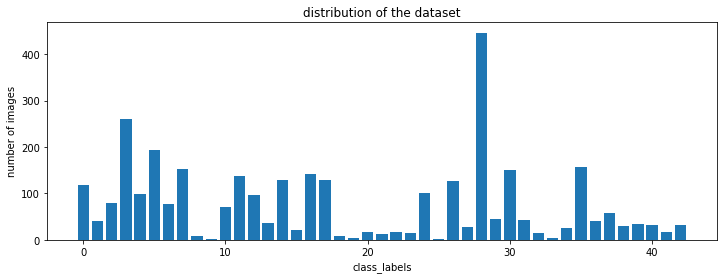

In [23]:
plt.figure(figsize=(12,4))
plt.bar(range(0, len(df)), num_samples)
plt.title('distribution of the dataset')
plt.xlabel('class_labels')
plt.ylabel('number of images')
plt.show()

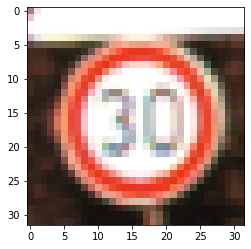

In [24]:
plt.imshow(train_x[3000])


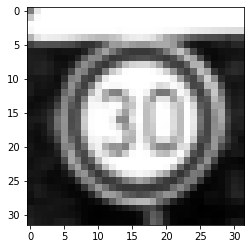

In [25]:
def grayscale(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

img = grayscale(train_x[3000])
plt.imshow(img, cmap = plt.get_cmap('gray'))

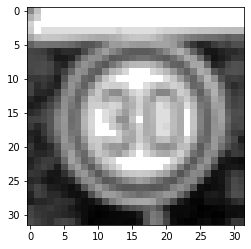

In [26]:
def equalize(image):
    image = cv2.equalizeHist(image)
    return image
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [27]:
def processing(image):
    gray_img = grayscale(image)
    img = equalize(gray_img) 
    img = img/255
    return img

In [28]:
train_x = np.asarray(list(map(processing, train_x)))
val_x = np.asarray(list(map(processing, val_x)))
test_x = np.asarray(list(map(processing, test_x)))

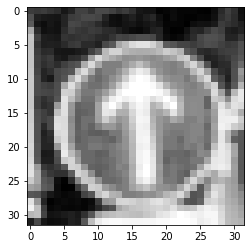

In [29]:
plt.imshow(train_x[random.randint(0, len(train_x-1))],cmap=plt.get_cmap('gray'))


In [30]:
train_x.shape[0]


34799

In [31]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
val_x = val_x.reshape(val_x.shape[0],val_x.shape[1],val_x.shape[2],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)

In [32]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(train_x)
#batches = datagen.flow(train_x,train_y,batch_size=15)

In [33]:
train_y = to_categorical(train_y,43)
test_y = to_categorical(test_y,43)
val_y = to_categorical(val_y,43)

In [34]:
from keras.layers import ReLU
def build_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5),input_shape=(train_x.shape[1],train_x.shape[2],train_x.shape[3])))
    model.add(ReLU())
    model.add(Conv2D(60,(5,5)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30,(3,3)))
    model.add(ReLU())
    model.add(Conv2D(30,(3,3)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(df['ClassId']),activation='softmax'))
    
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy",metrics=["accuracy"])
    return model
    

In [35]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 re_lu (ReLU)                (None, 28, 28, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 re_lu_1 (ReLU)              (None, 24, 24, 60)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
history = model.fit_generator(datagen.flow(train_x,train_y,batch_size=64),
                             steps_per_epoch=150,
                             epochs=15,
                             validation_data=(val_x,val_y),shuffle=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/15
150/150 [==============================] - 113s 749ms/step - loss: 3.2960 - accuracy: 0.1274 - val_loss: 1.9911 - val_accuracy: 0.4506
Epoch 2/15
150/150 [==============================] - 112s 744ms/step - loss: 1.8838 - accuracy: 0.4566 - val_loss: 0.8649 - val_accuracy: 0.7440
Epoch 3/15
150/150 [==============================] - 113s 755ms/step - loss: 1.2266 - accuracy: 0.6279 - val_loss: 0.5093 - val_accuracy: 0.8379
Epoch 4/15
150/150 [==============================] - 114s 758ms/step - loss: 0.9336 - accuracy: 0.7153 - val_loss: 0.3741 - val_accuracy: 0.8776
Epoch 5/15
150/150 [==============================] - 112s 745ms/step - loss: 0.7365 - accuracy: 0.7766 - val_loss: 0.2407 - val_accuracy: 0.9365
Epoch 6/15
150/150 [==============================] - 111s 742ms/step - loss: 0.6153 - accuracy: 0.8119 - val_loss: 0.1885 - val_accuracy: 0.9501
Epoch 7/15
150/150 [==============================] - 113s 752ms/step - loss: 0.5182 - accuracy: 0.8423 - val_loss: 0.1459 -

Text(0, 0.5, 'loss')

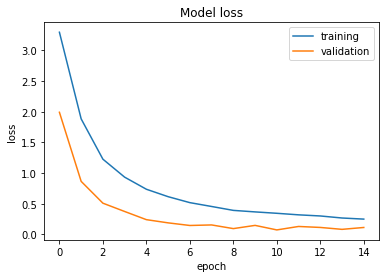

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [38]:
score = model.evaluate(test_x, test_y , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.1932905614376068
The Accuracy score is:  0.9452890157699585


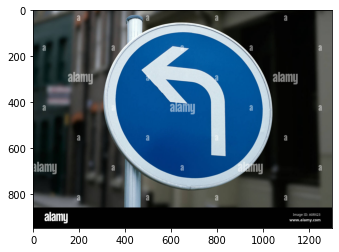

In [39]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)

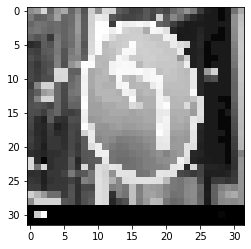

In [40]:
img = np.asarray(img)
img = cv2.resize(img,(32,32))
img = processing(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [41]:
df.columns

Index(['ClassId', 'SignName'], dtype='object')

In [49]:
import tensorflow

In [54]:
img = img.reshape(1,32,32,1)

predictions = (model.predict(img) > 0.5).astype("int32")

print('Predicted class is ',str(predictions))
#print('The traffic sign is ',df['SignName'][int(predictions)])

1/1 [==============================] - 0s 23ms/step
Predicted class is  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0]]
